In [391]:
import cv2
import numpy as np
import math
from numpy.fft import fft2, ifft2, fftshift, ifftshift
from scipy import signal
from matplotlib import pyplot as plt

In [392]:
def scaleSpectrum(A):
    #another method, have different effect
    #return 20*np.log(np.abs(A))
    return np.real(np.log10(np.absolute(A) + np.ones(A.shape)))

In [393]:
def FFT(img):
    f = fft2(img)
    fshift = fftshift(f)
    return fshift

def invFFT(fimg):
    return ifft2(ifftshift(fimg))

In [394]:
def GaussianFitler(size, sigma, highPass=False):
    """
        Create the (size * size) Matrix of gaussian filter
        Assume that size is odd number

        args:
            size : the size of kernal matrix
            sigma: simga of 2-d gaussian 
            highPass: if it's true, the return Gaussian high pass filter otherwise Gaussian low pass filter. Default false
        return:
            filter: guassian kernal matrix 
    """
    # Form the 2-D coordination for calculating probability of 2-d gaussian in each (i, j) position
    x, y = np.mgrid[-size/2+0.5 : size/2, -size/2+0.5 : size/2]  
    
    # calculate probability of 2-d gaussian in each (i, j) position
    coeff = np.exp(-( x**2 +  y**2) / (2 * sigma**2))
    coeff = coeff / coeff.sum()
    GS_filter = 1 - coeff if highPass else coeff
    
    return GS_filter 

In [395]:
def GaussianBlur(img, kernal_size = 3):
    kernal = GaussianFitler(3, 1, False) # create gaussian filter matrix
    blur_img = signal.convolve2d(img, kernal, mode="same", boundary="wrap") # Gaussian blur process
    
    return blur_img

In [396]:
# Nearest neighbor interpolation
def downsampling(img):
    h, w = img.shape
    #print(h, " ", w)
    arr_row, arr_col = np.arange(h), np.arange(w)
    
    # remove the even row, remain odd (index start at 0, so remove row if row %2 == 0)
    reduce_row = img[arr_row % 2 == 0]  # if row % 2 == 0, remain it
    # remove the even column (index start at 0, so col %2 == 0)
    new_img = reduce_row[:, arr_col % 2 == 0]
    return new_img

In [397]:
def upsampling(img):
    # repeat each row 
    repeat_row = np.repeat(img, 2, axis = 0)
    new_img = np.repeat(repeat_row, 2, axis=1)
    #print(new_img)
    return new_img

In [398]:
def GaussianPyrDown(img):
    # Correspond to cv2.pyrDown(), implement it from scratch
    
    # First, applying Gaussian blur
    blur_img = GaussianBlur(img)
    
    # Second, downsampling
    Gaussian_downsampling_img = downsampling(blur_img)
    
    return Gaussian_downsampling_img

In [399]:
def GaussianPyrUp(img):
    # Correspond to cv2.pyrUp(), implement it from scratch
    upsampling_img = upsampling(img)
    Gaussian_upsampling_img = GaussianBlur(upsampling_img)
    return Gaussian_upsampling_img
    

In [400]:
def substract(A, B):
    new_img = np.zeros(A.shape)
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            new_img[i, j] = A[i, j] - B[i, j]
    return new_img

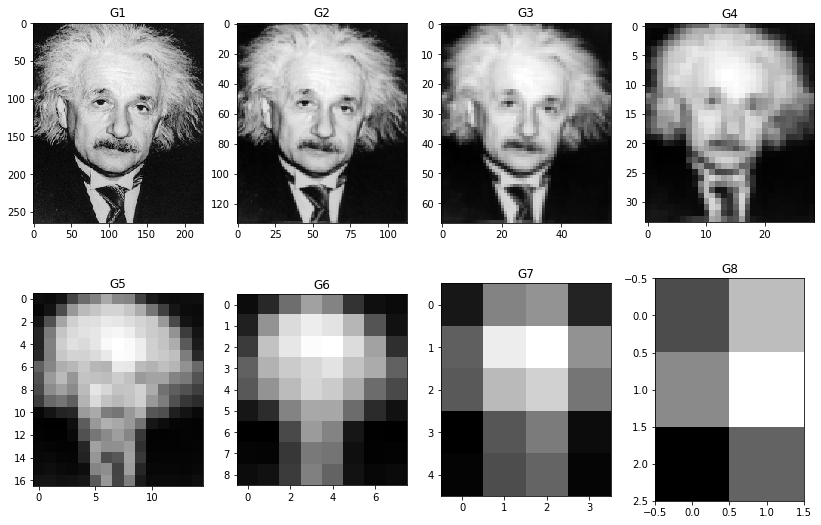

In [401]:
# Set the fileName to read
fileName = '4_einstein'
img = cv2.imread('hw2_data/task1and2_hybrid_pyramid/' + fileName +'.bmp')
plt.figure(num='Gaussian Pyramid', figsize=(14,9))

"""
Gaussian Pyramid
"""
numlayer = 7
GP_list = list()
# G1 - origin img
G1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)   # translate BGR channel to grayscale
GP_list.append(G1)

# G2 ~ G(layer+1)
for i in range(numlayer):
    GP = GaussianPyrDown(GP_list[i])
    GP_list.append(GP)


# plot img
for i in range(numlayer + 1):
    plt.subplot(2, 4, i + 1)
    plt.title("G" + str(i + 1))
    plt.imshow(GP_list[i], cmap='gray')

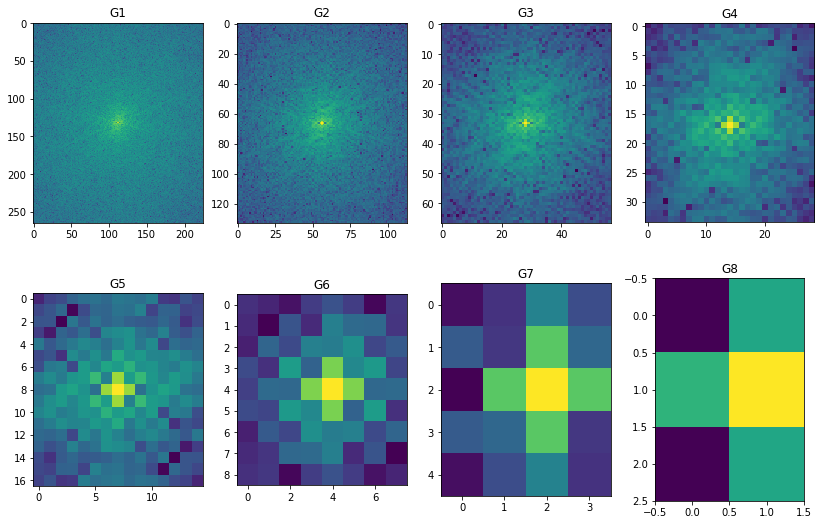

In [402]:
"""
Gaussian Pyramid Spectrum
"""
plt.figure(num='Gaussian Pyramid Spectrum', figsize=(14,9))
# plot img
for i in range(numlayer + 1):
    plt.subplot(2, 4, i + 1)
    plt.title("G" + str(i + 1))
    plt.imshow(scaleSpectrum(FFT(GP_list[i])))

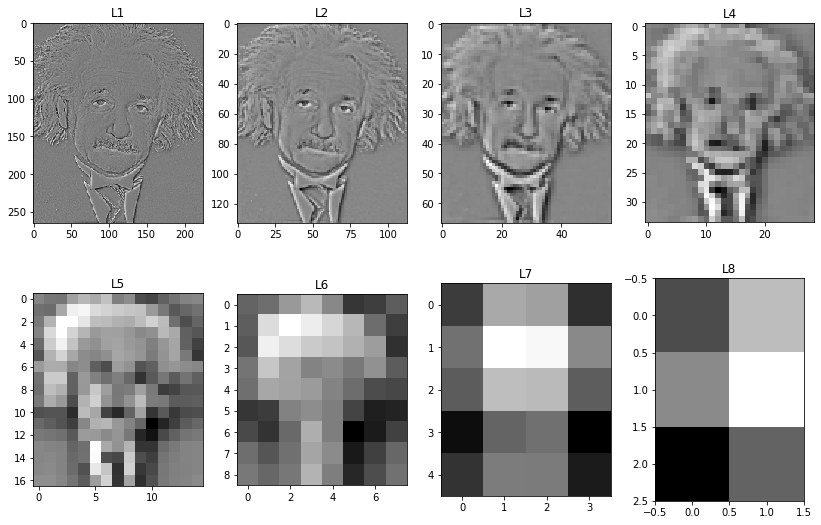

In [403]:
"""
Laplacian Pyramid
"""
plt.figure(num='Laplacian Pyramid', figsize=(14,9))

LP_list = list()
LP_list.append(GP_list[numlayer]) # add L1
# L2 ~ L(layer+1)
for i in range(numlayer, 0, -1):
    GU = GaussianPyrUp(GP_list[i])
    LP  = substract(GP_list[i - 1], GU)
    LP_list.append(LP)

LP_list.reverse()
# plot img
for i in range(numlayer + 1):
    plt.subplot(2, 4, i + 1)
    plt.title("L" + str(i + 1))
    plt.imshow(LP_list[i], cmap='gray')

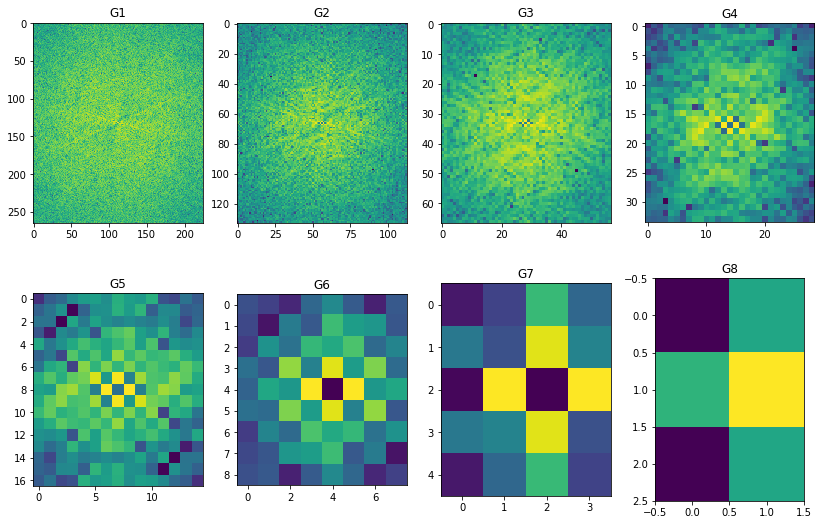

In [404]:
"""
Laplacian Pyramid Spectrum
"""
plt.figure(num='Laplacian Pyramid Spectrum', figsize=(14,9))
# plot img
for i in range(numlayer + 1):
    plt.subplot(2, 4, i + 1)
    plt.title("G" + str(i + 1))
    plt.imshow(scaleSpectrum(FFT(LP_list[i])))